### Main points
- Build duration prediction model with new york city taxi dataset
- Log parameters, tag with mlflow
- Parameter tuning with `hyperopt`
- Autolog with mlflow

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464354743487

C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


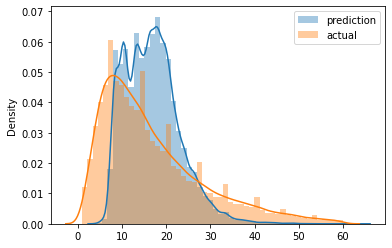

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479614645724615

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
with mlflow.start_run():
    mlflow.set_tag("developer", "godwin")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [16]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3)-exp(0)
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [21]:
params = {
    'learning_rate': 0.1425051270571374,
    'max_depth': 64,
    'min_child_weight':1.5207951824163422,
    'objective': 'reg:linear',
    'reg_alpha':0.011687770805985572,
    'reg_lambda':0.1544952462540449,
    'seed':42
}

mlflow.xgboost.autolog()
train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val) #enable autolog before creating data
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        

2023/05/25 10:55:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc8494d397584dce9cb18db34c306b41', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:55:21] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.64372
[1]	validation-rmse:16.49747
[2]	validation-rmse:14.69484
[3]	validation-rmse:13.19469
[4]	validation-rmse:11.94816
[5]	validation-rmse:10.91772
[6]	validation-rmse:10.07304
[7]	validation-rmse:9.38464
[8]	validation-rmse:8.82433
[9]	validation-rmse:8.37495
[10]	validation-rmse:8.01095
[11]	validation-rmse:7.71809
[12]	validation-rmse:7.48188
[13]	validation-rmse:7.29579
[14]	validation-rmse:7.14290
[15]	validation-rmse:7.01931
[16]	validation-rmse:6.92013
[17]	validation-rmse:6.84004
[18]	validation-rmse:6.77541
[19]	validation-rmse:6.72156
[20]	validation-rmse:6.67746
[21]	validation-rmse:6.63982
[22]	validation-rmse:6.60971
[23]	validation-rmse:6.58320
[24]	validation-rmse:6.55953
[25]	validation-rmse:6.54085
[26]	validation-rmse:6.52587
[27]	validation-rmse:6.51259
[28]	validation-rmse:6.50124
[29]	va

[272]	validation-rmse:6.34124
[273]	validation-rmse:6.34112
[274]	validation-rmse:6.34112
[275]	validation-rmse:6.34108
[276]	validation-rmse:6.34095
[277]	validation-rmse:6.34150
[278]	validation-rmse:6.34148
[279]	validation-rmse:6.34131
[280]	validation-rmse:6.34102
[281]	validation-rmse:6.34089
[282]	validation-rmse:6.34081
[283]	validation-rmse:6.34089
[284]	validation-rmse:6.34088
[285]	validation-rmse:6.34052
[286]	validation-rmse:6.34060
[287]	validation-rmse:6.34062
[288]	validation-rmse:6.34041
[289]	validation-rmse:6.34049
[290]	validation-rmse:6.33997
[291]	validation-rmse:6.33969
[292]	validation-rmse:6.33966
[293]	validation-rmse:6.34020
[294]	validation-rmse:6.33985
[295]	validation-rmse:6.33955
[296]	validation-rmse:6.33935
[297]	validation-rmse:6.33938
[298]	validation-rmse:6.33919
[299]	validation-rmse:6.33894
[300]	validation-rmse:6.33927
[301]	validation-rmse:6.33939
[302]	validation-rmse:6.33935
[303]	validation-rmse:6.33921
[304]	validation-rmse:6.33936
[305]	vali